In [31]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import cv2
from pathlib import Path

In [32]:
from IPython.display import display
from PIL import Image

def pic_show(img: np.ndarray):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img)
    display(pil_img)

In [33]:
from utils.utils import DATA_SET

ds_name, radius = DATA_SET[2]
root = Path.cwd()
wd = root / ('data/train/' + ds_name)
img_dir = wd / '02'
seg_dir = wd / '02_ST/SEG'
tra_dir = wd / '02_GT/TRA'

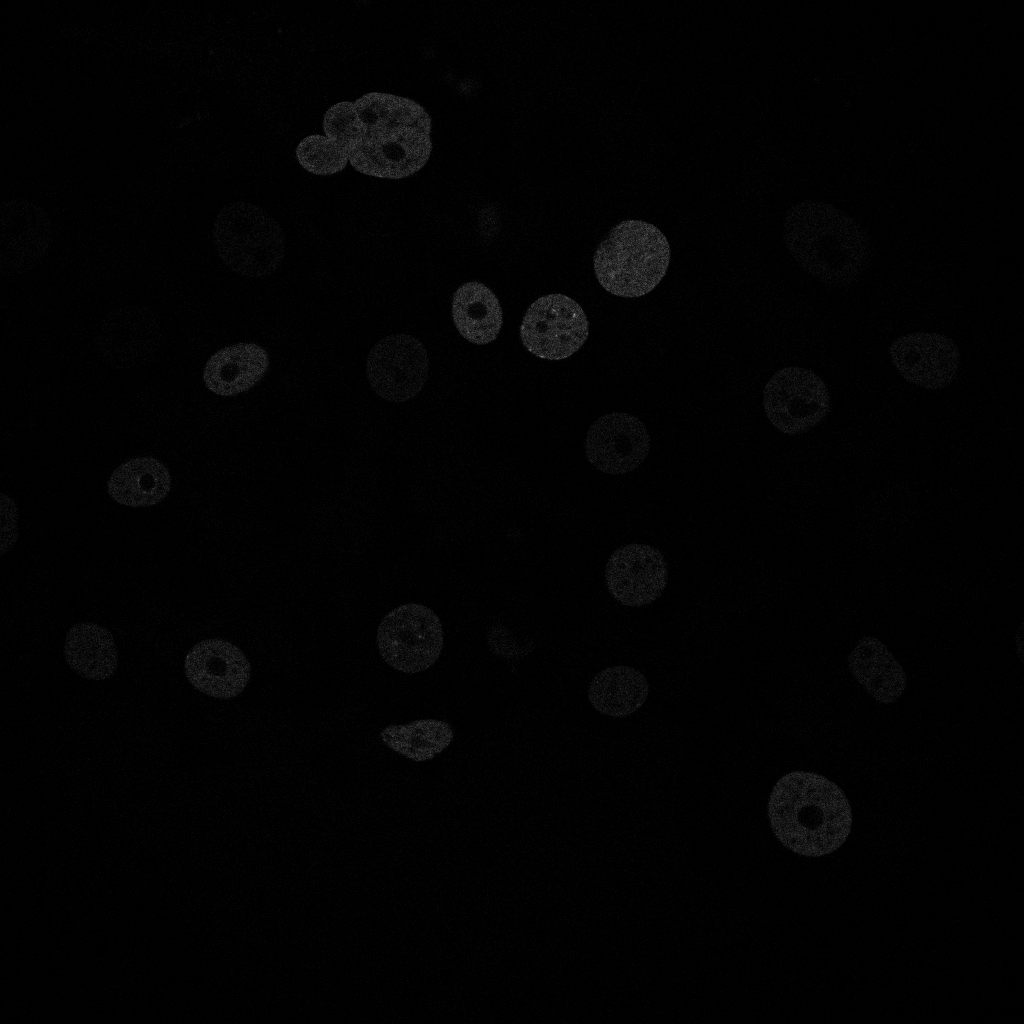

In [34]:
img_name = random.choice([f for f in img_dir.glob('*')])
seg_name = seg_dir / ('man_seg' + img_name.name[1:])
tra_name = tra_dir / ('man_track' + img_name.name[1:])
img = tifffile.imread(str(img_name))
seg = tifffile.imread(str(seg_name))
tra = tifffile.imread(str(tra_name))
seg_bin = 255 * np.uint8(seg > 0)
tra_bin = 255 * np.uint8(tra > 0)
# cv2.imshow('image', np.hstack((img, 255 * (mask / mask.max()))))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# im_list = [img, seg_bin, tra_bin]
# fig, axs = plt.subplots(1, len(im_list))
# for i in range(len(im_list)):
#     axs[i].imshow(im_list[i])
#     axs[i].set_xticks([])
#     axs[i].set_yticks([])
# plt.show()
pic_show(img)

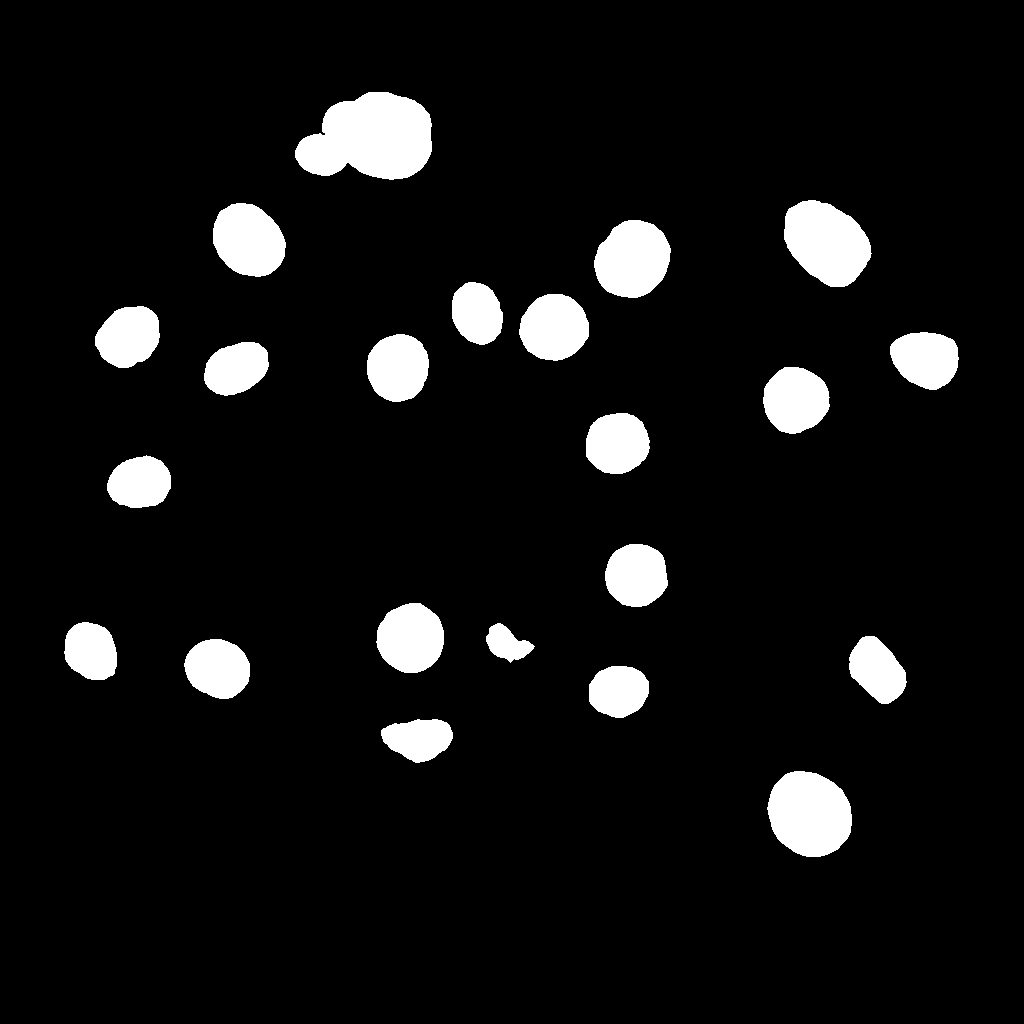

In [35]:
pic_show(seg_bin)

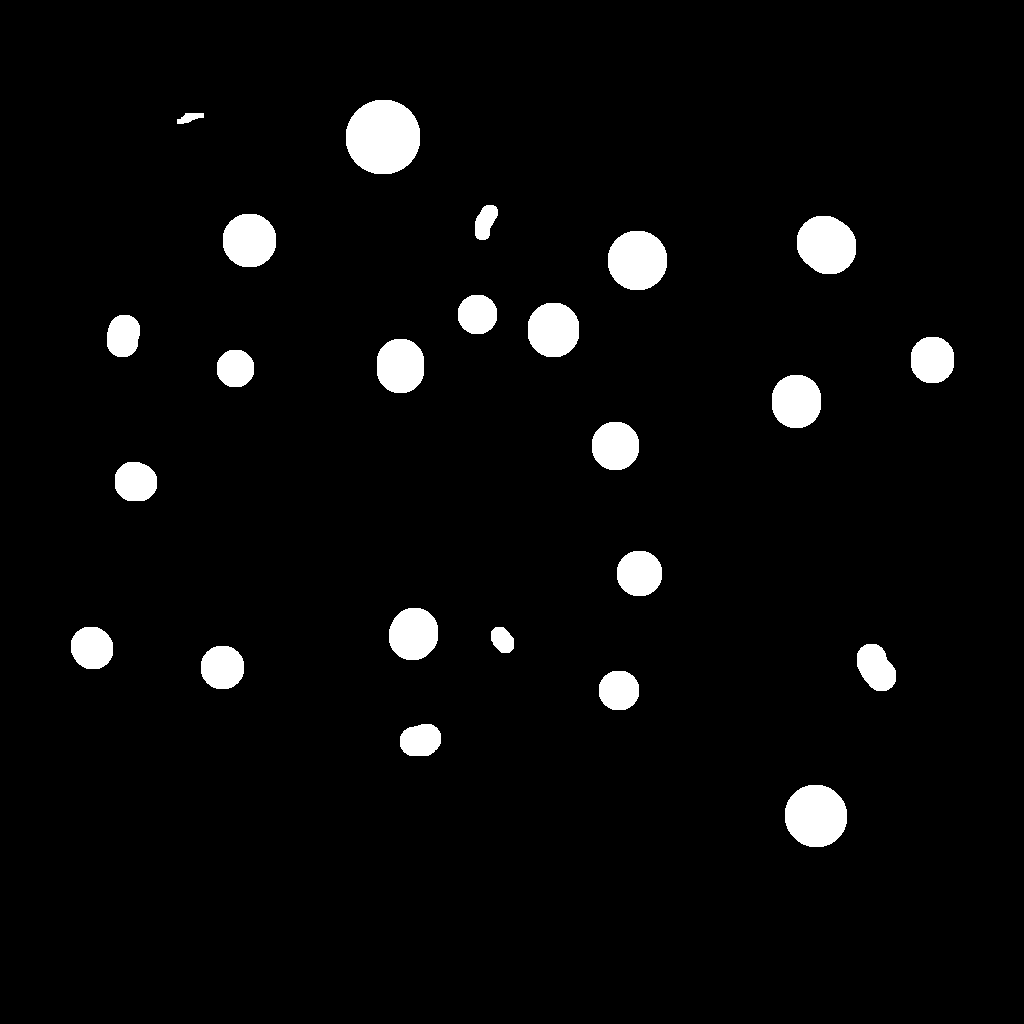

In [36]:
pic_show(tra_bin)

In [37]:
def stat(im):
    s = pd.Series(np.bincount(im.flatten()))
    return s[s != 0]
stat(tra)

0     1006819
2        2285
5        2809
9        2262
12       1245
13       2723
14       1642
15       2137
16       1836
17       1649
19       1337
20       2118
28       1125
29       1362
31       1438
32       1513
33       2061
34        460
36       1284
37       1087
38       3084
48        559
55       1149
56       4407
60        185
dtype: int64

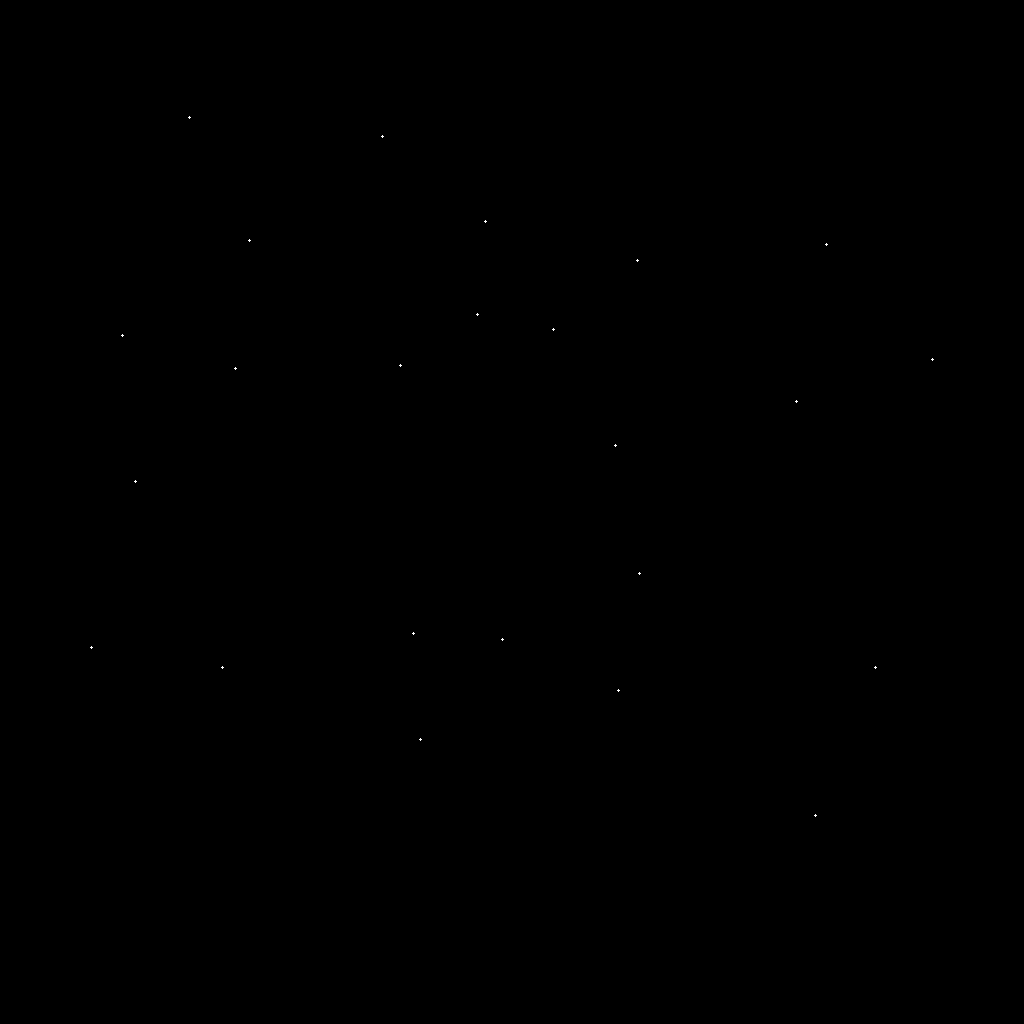

In [38]:
cnts, hier = cv2.findContours(tra_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
det_bin = np.zeros_like(tra_bin)
for cnt in cnts:
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
    else:
        while isinstance(cnt[0], np.ndarray):
            cnt = cnt[0]
        center = cnt
    cv2.circle(det_bin, center, 1, 255, -1)
pic_show(det_bin)

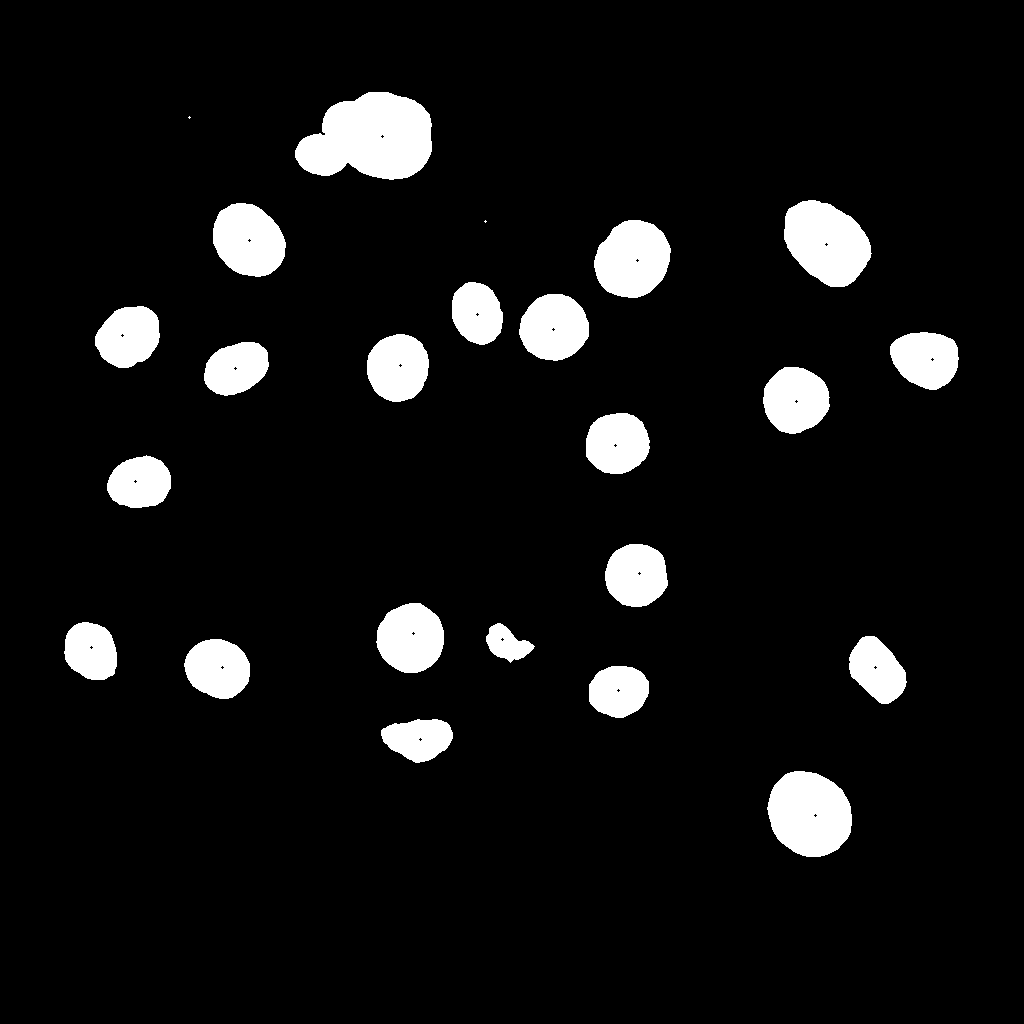

In [39]:
diff = cv2.absdiff(seg_bin, det_bin)
pic_show(diff)

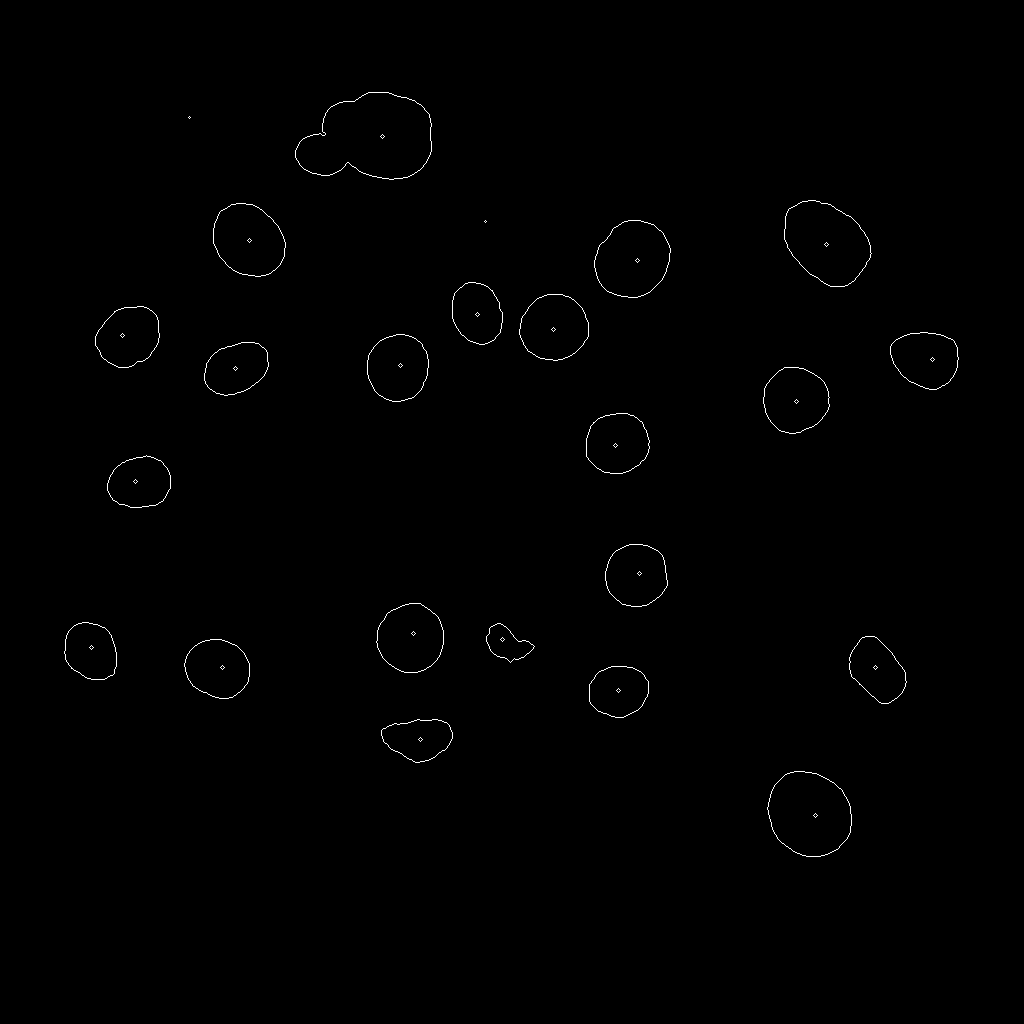

In [40]:
cnts, hier = cv2.findContours(diff, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
res = np.zeros_like(diff)
cv2.drawContours(res, cnts, -1, 255, 1)
pic_show(res)

In [41]:
hier = np.squeeze(hier)
hier

array([[ 2, -1,  1, -1],
       [-1, -1, -1,  0],
       [ 4,  0,  3, -1],
       [-1, -1, -1,  2],
       [ 6,  2,  5, -1],
       [-1, -1, -1,  4],
       [ 8,  4,  7, -1],
       [-1, -1, -1,  6],
       [10,  6,  9, -1],
       [-1, -1, -1,  8],
       [12,  8, 11, -1],
       [-1, -1, -1, 10],
       [14, 10, 13, -1],
       [-1, -1, -1, 12],
       [16, 12, 15, -1],
       [-1, -1, -1, 14],
       [18, 14, 17, -1],
       [-1, -1, -1, 16],
       [20, 16, 19, -1],
       [-1, -1, -1, 18],
       [22, 18, 21, -1],
       [-1, -1, -1, 20],
       [24, 20, 23, -1],
       [-1, -1, -1, 22],
       [26, 22, 25, -1],
       [-1, -1, -1, 24],
       [28, 24, 27, -1],
       [-1, -1, -1, 26],
       [30, 26, 29, -1],
       [-1, -1, -1, 28],
       [32, 28, 31, -1],
       [-1, -1, -1, 30],
       [34, 30, 33, -1],
       [-1, -1, -1, 32],
       [36, 32, 35, -1],
       [-1, -1, -1, 34],
       [38, 34, 37, -1],
       [-1, -1, -1, 36],
       [39, 36, -1, -1],
       [41, 38, 40, -1],


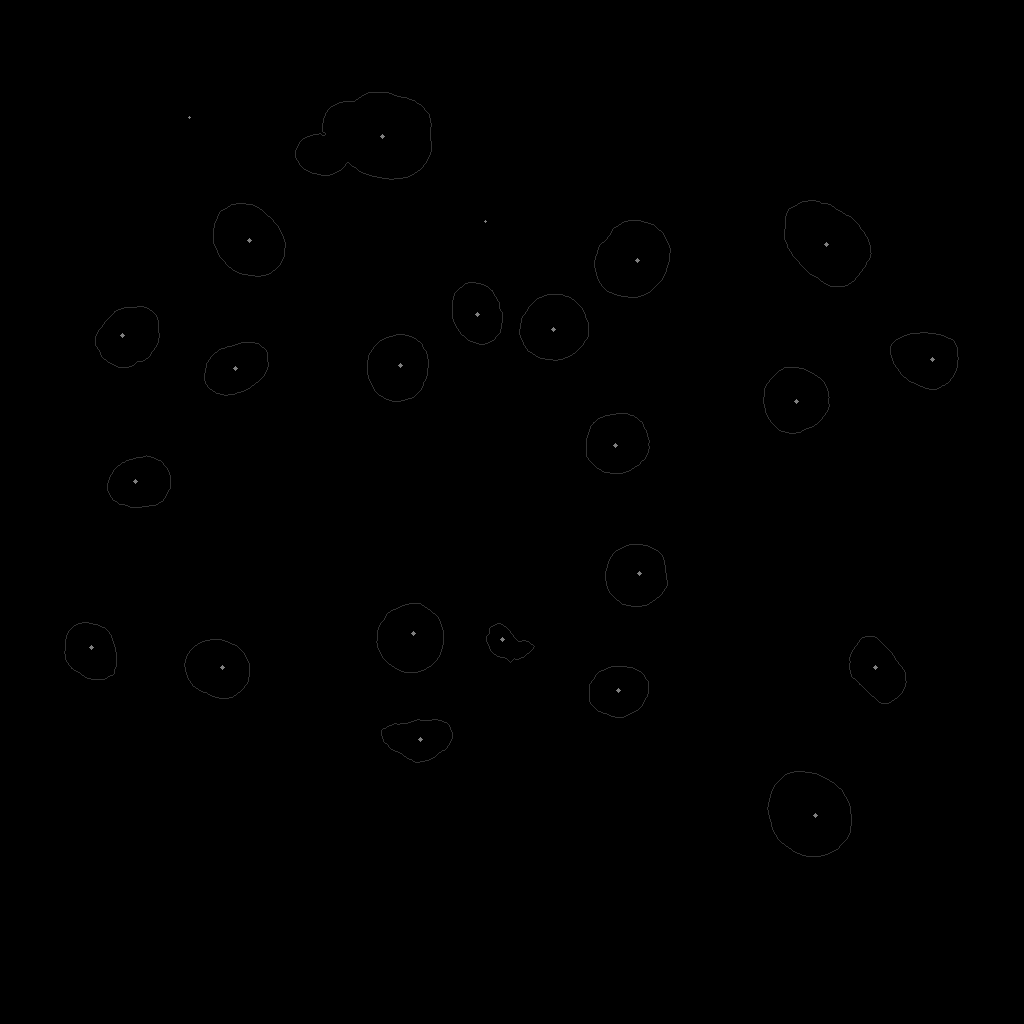

In [42]:
det_mask = np.zeros_like(diff)
seg_mask = np.zeros_like(diff)
for i in range(len(cnts)):
    first_child = hier[i, -2]
    parent = hier[i, -1]
    if first_child != -1:
        next_child = hier[first_child, 0]
        if next_child != -1:
            cv2.drawContours(det_mask, cnts, first_child, 255, -1)
            cv2.drawContours(det_mask, cnts, next_child, 255, -1)

            cv2.drawContours(seg_mask, cnts, i, 255, -1)
        else:
            cv2.drawContours(det_mask, cnts, first_child, 127, -1)

            cv2.drawContours(seg_mask, cnts, i, 127, -1)
        cv2.drawContours(det_mask, cnts, i, 50, 1)
    elif parent == -1:
        cv2.drawContours(det_mask, cnts, i, 127, -1)
pic_show(det_mask)

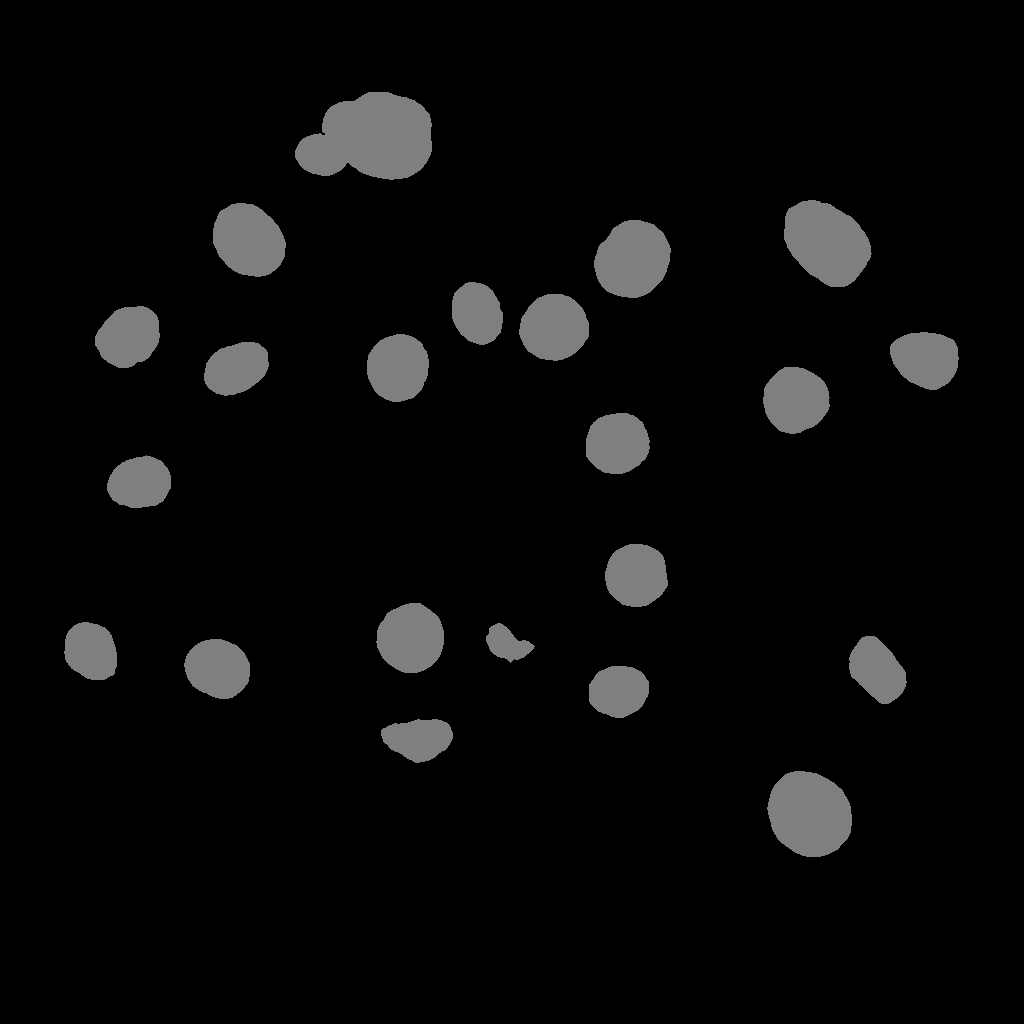

In [43]:
pic_show(seg_mask)

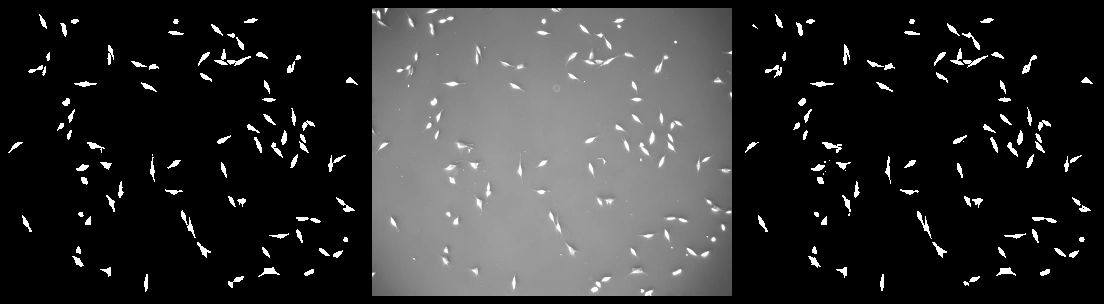

In [46]:
pred = cv2.imread(str(root / 'pred_ming.bmp'), -1)
pic_show(pred)